In [1]:
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
pd.set_option('display.max_columns', 500)
sns.set_style("ticks")

# I - Importation et nettoyage des données

In [4]:
PATH = '/home/steve/Documents/ENSAE/Projet_ML_Tennis/Data/tennis_atp/'

In [5]:
data = pd.read_csv(PATH+'atp_matches_2010.csv')
for annee in range(2000, 2020):
    data = pd.concat([data, pd.read_csv(PATH+'atp_matches_'+str(annee)+'.csv')], axis=0, sort=False)

In [6]:
data.reset_index(inplace=True, drop=True)

In [7]:
data.shape

(64694, 49)

In [8]:
data['tourney_date'] = pd.to_datetime(data['tourney_date'], yearfirst=True, format='%Y%m%d')
data['year'] = data['tourney_date'].apply(lambda x: x.year)
data = data[~data['tourney_name'].str.startswith('Davis Cup')].copy()
data.dropna(subset=['minutes'], inplace=True)

In [9]:
def contains_ascii_letter(txt):
    gate = False
    for i in range(len(txt)):
        if txt[i] in string.ascii_letters:
            gate = True
            break
    return gate

In [10]:
get_ascii_letter = np.zeros(data.shape[0], dtype=bool)
get_ascii_letter = data['score'].apply(contains_ascii_letter)

data = data[~get_ascii_letter].copy()

In [11]:
data.shape

(54515, 50)

### Corrections
En étudiant les valeurs extrêmes de notre jeu de données nous avons constaté la présence de quelques erreurs concernant la durée de certains matchs. Nous avons constaté que trois matchs étaient anormalement long. Sur les trois, deux étaient en effet des erreurs de saisis cependant, le troisième correspond au match de Wimbledon (2010) entre Josh Ishner et Nicolas Mahut qui a duré 11h05 s'étalant sur trois jours. On notera que John Ishner est un habitué des longs matchs avec 3 apparitions dans le top 10 des plus longs matchs de l'histoire du tennis.

In [12]:
data[(data['tourney_id']=='2017-0308')&(data['match_num']==297)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
57395,2017-0308,Munich,Clay,32,A,2017-05-01,297,111202,NaN,NaN,Hyeon Chung,R,NaN,KOR,20.950034,105373,NaN,NaN,Martin Klizan,L,190.0,SVK,27.805613,6-4 3-6 6-2,3,QF,987.0,4.0,2.0,81.0,47.0,36.0,15.0,13.0,4.0,6.0,8.0,4.0,95.0,49.0,28.0,27.0,14.0,8.0,12.0,78.0,659.0,53.0,880.0,2017


In [13]:
data.at[1257, 'minutes'] = 98

In [14]:
data.at[1257, 'minutes']

98.0

In [15]:
data[(data['tourney_id']=='2016-M001')&(data['match_num']==294)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
53329,2016-M001,Sydney,Hard,32,A,2016-01-11,294,104180,NaN,NaN,Gilles Muller,L,193.0,LUX,32.676249,104871,6,NaN,Jeremy Chardy,R,188.0,FRA,28.911704,7-6(5) 6-3,3,QF,1146.0,14.0,5.0,59.0,35.0,32.0,13.0,10.0,0.0,0.0,2.0,5.0,69.0,44.0,34.0,10.0,11.0,1.0,3.0,38.0,1105.0,31.0,1255.0,2016


In [16]:
data.at[132, 'minutes'] = 90

## Etudes marcoscopique de ce qui influe sur la durée d'un match de tennis

Tout d'abord nous pouvons nous demander quels sont les facteurs qui influent le plsu sur la durée d'un match de tennis. <br>
Liste résumant ces points : <br>
1) Le nombre de sets nécessaires pour gagner le match (best of 3 / best of 5) <br>
2) La surface sur laquelle ce joue le match (clay / hard / grass / carpet) <br>
3) Le type de tournois (Grand Slam / Master / Other / Challenger / Satellite) <br>
4) Le niveau du tournois du match (32eme / 16eme / 8eme ...) <br>
5) La différence de ranking entre les deux joueurs <br> 
6) Le ranking moyen des deux joueurs (est ce que les joueurs de meilleur niveau on tendance à jouer plus rapidement ou non ?)

In [17]:
data.groupby(['best_of'])['minutes'].mean()

best_of
3.0     96.717804
5.0    148.814782
Name: minutes, dtype: float64

In [18]:
avg_best_of_3_all = data.groupby(['best_of'])['minutes'].mean()[3]

In [19]:
avg_best_of_5_all = data.groupby(['best_of'])['minutes'].mean()[5]

### La surface du terrain

In [20]:
colormap = plt.get_cmap('Set1')

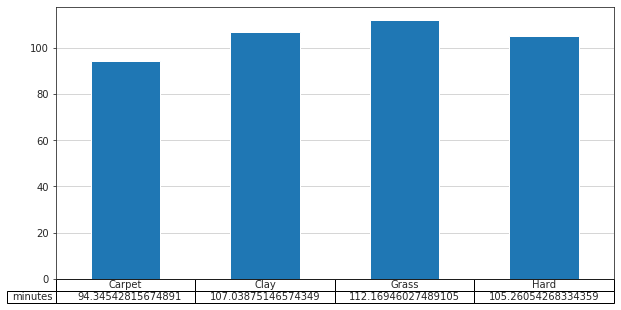

In [21]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['surface'])['minutes'].mean().plot(kind='bar',figsize=(10,5), table=True, grid=True)

Ici on voit que les matchs sur gazon (Grass) on tendance à être plus long que sur les autres surface. Cependant ce résultat est contre intuitif. En effet, il est connu que la surface où la balle va la plus vite et offrant le moins de rebond est le gazon. Il est serait donc normal que les matchs les plus court est lieu sur cette surface.<br><br>
Nous allons affiner l'analyse en séparant les matchs best_of_3 des matchs best_of_5.

In [22]:
data.groupby(['best_of', 'surface'])['match_num'].count().unstack()

surface,Carpet,Clay,Grass,Hard
best_of,,,,
3.0,1364,15306,3521,24271
5.0,14,2603,2445,4991


On s'aperçoit que le ratio de match best_of_3/best_of_5 est proche de 1 pour le gazon tandis que sur les autres surfaces il y beaucoup plus de matchs en 3 que en 5. Ceci explique que nla moyenne globale de la durée des matchs sur gazons soit plus élevées que sur les autres matières. <br>
Afin de ne pas biaiser la suite de notre analyse, nous veillerons à toujours séparer ces deux catégories. 

In [23]:
data.groupby(['best_of', 'surface'])['minutes'].mean()

best_of  surface
3.0      Carpet      93.687683
         Clay        99.432053
         Grass       90.720534
         Hard        96.046434
5.0      Carpet     158.428571
         Clay       151.767192
         Grass      143.057669
         Hard       150.068323
Name: minutes, dtype: float64

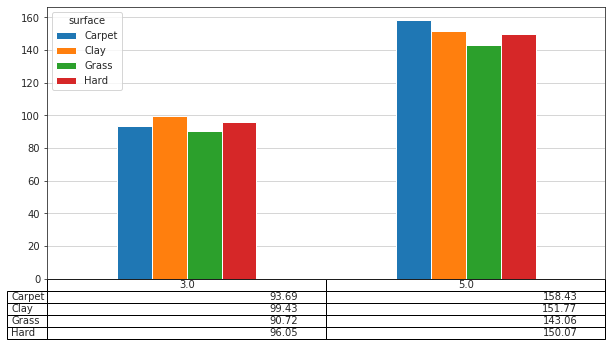

In [24]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'surface'])['minutes'].mean().unstack().plot(kind='bar', figsize=(10,5),
                                                                      table=np.round(data.groupby(['best_of', 'surface'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

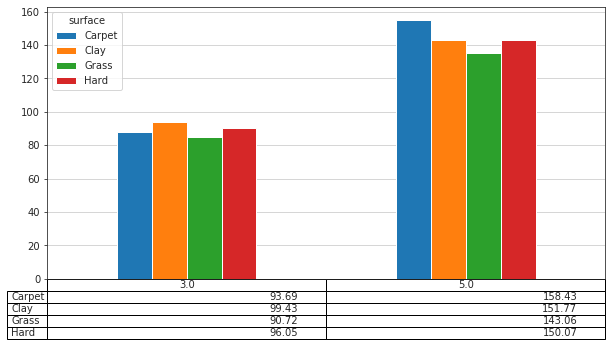

In [25]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'surface'])['minutes'].median().unstack().plot(kind='bar', figsize=(10,5),
                                                                      table=np.round(data.groupby(['best_of', 'surface'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

On voit ici qu'en effet la surface al plus rapide est le gazon et la plus lente est la terre battue ou la moquette. 

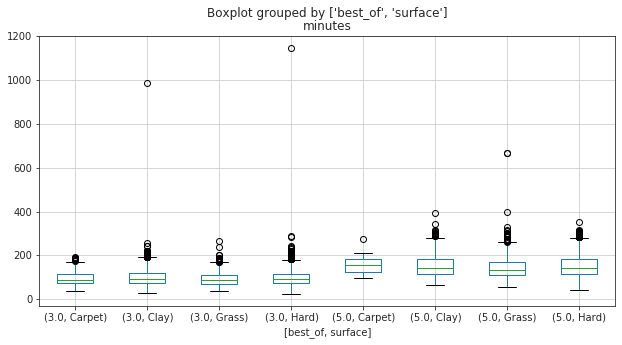

In [26]:
data.boxplot(column=['minutes'], by=['best_of', 'surface'], figsize=(10,5))

In [27]:
data.groupby(['best_of', 'surface'])['match_num'].count()

best_of  surface
3.0      Carpet      1364
         Clay       15306
         Grass       3521
         Hard       24271
5.0      Carpet        14
         Clay        2603
         Grass       2445
         Hard        4991
Name: match_num, dtype: int64

### Le type de tournois 

The different tournament tiers are represented by single letters: 'G' = Grand Slams, 'M' = Masters 100s, 'A' = other tour-level events, 'C' = Challengers, 'S' = Satellites/ITFs, 'F' = Tour finals and other season-ending events

In [28]:
data.groupby(['best_of', 'tourney_level'])['minutes'].mean().unstack()

tourney_level,A,F,G,M
best_of,,,,
3.0,95.839255,104.003460,NaN,99.112181
5.0,160.522727,148.142857,148.714257,160.500000


In [29]:
data.groupby(['best_of', 'tourney_level'])['minutes'].median().unstack()

tourney_level,A,F,G,M
best_of,,,,
3.0,90.0,98.0,NaN,93.0
5.0,148.0,115.0,141.0,140.5


In [30]:
data.groupby(['best_of', 'tourney_level'])['minutes'].describe()

count        mean        std   min     25%    50%  \
best_of tourney_level                                                        
3.0     A              32959.0   95.839255  30.774638  25.0   72.00   90.0   
        F                289.0  104.003460  32.292661  50.0   78.00   98.0   
        M              11214.0   99.112181  30.653832  28.0   75.00   93.0   
5.0     A                 44.0  160.522727  48.522107  93.0  123.50  148.0   
        F                  7.0  148.142857  72.792922  96.0   98.00  115.0   
        G               9960.0  148.714257  46.378831  43.0  113.00  141.0   
        M                 42.0  160.500000  54.591275  93.0  120.25  140.5   

                         75%     max  
best_of tourney_level                 
3.0     A              116.0  1146.0  
        F              126.0   218.0  
        M              120.0   244.0  
5.0     A              185.5   300.0  
        F              178.5   273.0  
        G              179.0   665.0  
        M              188.0   314.0

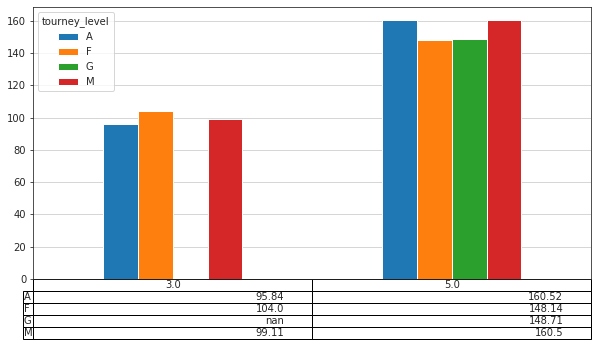

In [31]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'tourney_level'])['minutes'].mean().unstack().plot(kind='bar', figsize=(10,5),
                                                                      table=np.round(data.groupby(['best_of', 'tourney_level'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

### Le round

In [32]:
data.groupby(['best_of', 'round'])['minutes'].mean().unstack()

round,BR,ER,F,QF,R128,R16,R32,R64,RR,SF
best_of,,,,,,,,,,
3.0,138.0,85.96875,105.160988,99.246479,98.002555,97.180967,94.873088,95.414547,99.254669,101.779723
5.0,NaN,NaN,166.891429,159.850318,145.512171,156.536392,150.822115,148.685908,NaN,166.706250


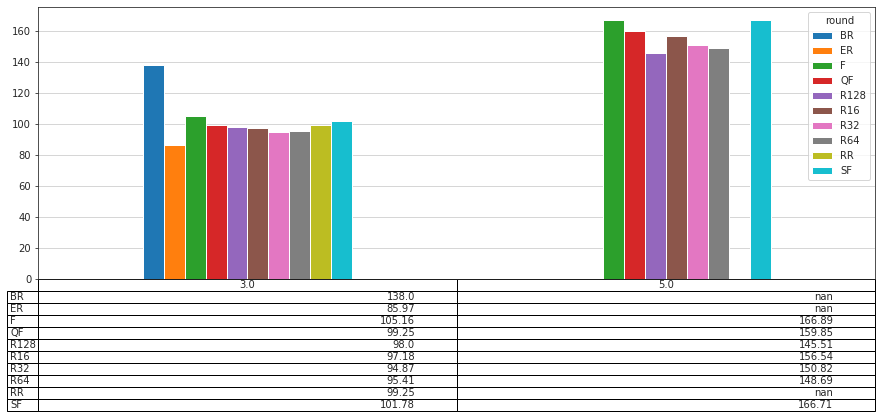

In [33]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'round'])['minutes'].mean().unstack().plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'round'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

### La différence de ranking entre les deux joueurs

In [34]:
data['diff_ranking'] = data.apply(lambda x: abs(x.winner_rank - x.loser_rank), axis=1)

In [35]:
data['diff_ranking'].describe()

count    54358.000000
mean        71.653850
std        111.445747
min          1.000000
25%         19.000000
50%         41.000000
75%         79.000000
max       2125.000000
Name: diff_ranking, dtype: float64

In [36]:
data[data['diff_ranking']==2125]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year,diff_ranking
47418,2014-451,Doha,Hard,32.0,A,2013-12-30,12.0,104918.0,3,NaN,Andy Murray,R,190.0,GBR,26.628337,110476.0,NaN,WC,Mousa Shanan Zayed,U,NaN,QAT,19.811088,6-0 6-0,3.0,R32,37.0,3.0,3.0,32.0,20.0,20.0,4.0,6.0,0.0,0.0,0.0,2.0,34.0,16.0,4.0,5.0,6.0,3.0,9.0,4.0,5790.0,2129.0,1.0,2013.0,2125.0


In [37]:
data[data['diff_ranking']>79]['diff_ranking'].describe()

count    13569.000000
mean       190.897487
std        171.582729
min         80.000000
25%         98.000000
50%        130.000000
75%        206.000000
max       2125.000000
Name: diff_ranking, dtype: float64

In [38]:
data[data['diff_ranking']>206]['diff_ranking'].describe()

count    3379.000000
mean      402.518497
std       234.871529
min       207.000000
25%       247.000000
50%       317.000000
75%       465.000000
max      2125.000000
Name: diff_ranking, dtype: float64

In [39]:
data[data['diff_ranking']>466]['diff_ranking'].describe()

count     832.000000
mean      729.682692
std       258.776447
min       467.000000
25%       530.000000
50%       652.500000
75%       846.250000
max      2125.000000
Name: diff_ranking, dtype: float64

In [40]:
data[data['diff_ranking']>1000]['diff_ranking'].describe()

count     116.000000
mean     1232.250000
std       228.866997
min      1002.000000
25%      1061.250000
50%      1176.500000
75%      1334.250000
max      2125.000000
Name: diff_ranking, dtype: float64

In [41]:
data['diff_ranking_categories'] = pd.cut(data['diff_ranking'], [0,20,50,79,206,466,1000,3000])

In [42]:
data.groupby(['best_of', 'diff_ranking_categories'])['minutes'].mean().unstack()

diff_ranking_categories,"(0, 20]","(20, 50]","(50, 79]","(79, 206]","(206, 466]","(466, 1000]","(1000, 3000]"
best_of,,,,,,,
3.0,98.903534,97.431936,96.113912,94.901978,92.796382,87.488152,75.686275
5.0,157.459829,151.364298,145.307614,142.940977,134.895141,136.421687,134.071429


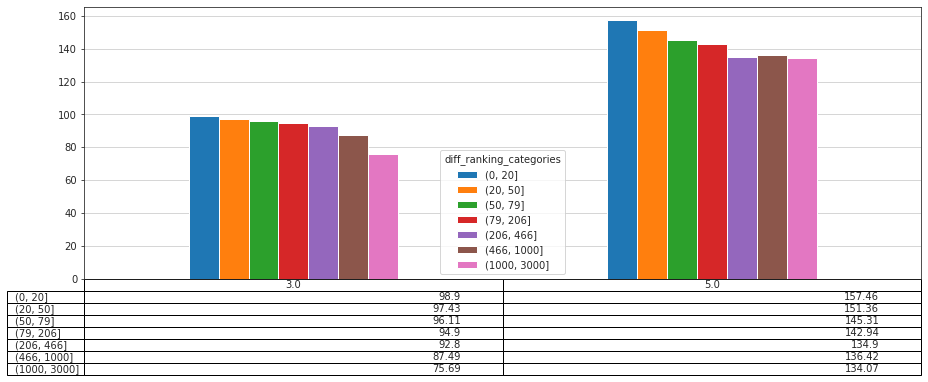

In [43]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'diff_ranking_categories'])['minutes'].mean().unstack().plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'diff_ranking_categories'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

In [44]:
data[['minutes', 'diff_ranking']].corr()

,minutes,diff_ranking
minutes,1.000000,-0.063598
diff_ranking,-0.063598,1.000000


### Ranking moyen 

In [45]:
data['avg_ranking'] = data.apply(lambda x: (x.winner_rank + x.loser_rank)/2, axis=1)

In [46]:
data['avg_ranking'].describe()

count    54358.000000
mean        75.231925
std         71.599931
min          1.500000
25%         35.500000
50%         58.000000
75%         90.000000
max       1484.000000
Name: avg_ranking, dtype: float64

In [47]:
data[data['avg_ranking']>90]['avg_ranking'].describe()

count    13555.000000
mean       160.194098
std         97.206507
min         90.500000
25%        104.000000
50%        126.500000
75%        175.000000
max       1484.000000
Name: avg_ranking, dtype: float64

In [48]:
data[data['avg_ranking']>174]['avg_ranking'].describe()

count    3420.000000
mean      282.143129
std       126.791981
min       174.500000
25%       198.500000
50%       238.000000
75%       315.500000
max      1484.000000
Name: avg_ranking, dtype: float64

In [49]:
data[data['avg_ranking']>376]['avg_ranking'].describe()

count     522.000000
mean      525.947318
std       139.960834
min       376.500000
25%       425.000000
50%       490.250000
75%       577.875000
max      1484.000000
Name: avg_ranking, dtype: float64

In [50]:
data['avg_ranking_categories'] = pd.cut(data['avg_ranking'], [0,35,60,90,125,240,500,1500])

In [51]:
data.groupby(['best_of', 'avg_ranking_categories'])['minutes'].mean().unstack()

avg_ranking_categories,"(0, 35]","(35, 60]","(60, 90]","(90, 125]","(125, 240]","(240, 500]","(500, 1500]"
best_of,,,,,,,
3.0,99.892345,97.032786,95.834359,95.346388,94.488605,91.639434,83.668161
5.0,155.778074,146.278750,147.317411,145.449556,147.140330,136.904762,146.916667


In [52]:
data[['minutes', 'avg_ranking']].corr()

,minutes,avg_ranking
minutes,1.000000,-0.079169
avg_ranking,-0.079169,1.000000


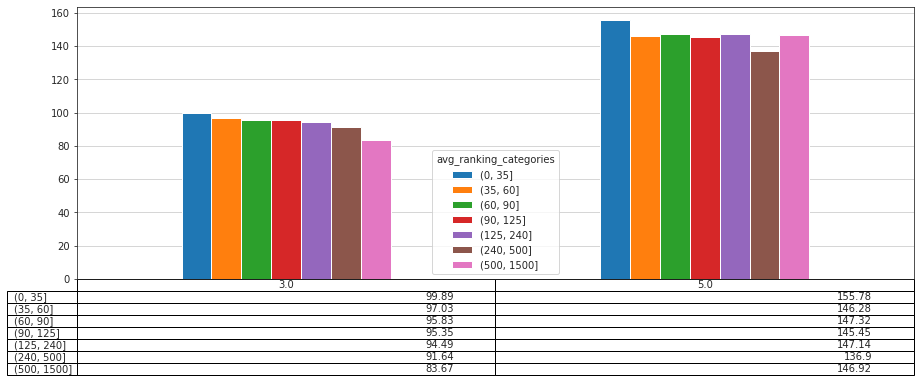

In [53]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'avg_ranking_categories'])['minutes'].mean().unstack().plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'avg_ranking_categories'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

### Analyse du top 500 des matchs les plus rapides

In [76]:
top_1000_rapides_b03 = data[data['best_of']==3].nsmallest(1000, 'minutes')
top_1000_rapides_b05 = data[data['best_of']==5].nsmallest(1000, 'minutes')

###  Analyse du top 500 des matchs les plus lents

In [77]:
top_1000_lents_b03 = data[data['best_of']==3].nlargest(1000, 'minutes')
top_1000_lents_b05 = data[data['best_of']==5].nlargest(1000, 'minutes')

Comparer les moyenne des ranks dans les différents matchs. On voit que dans les matchs les plus rapides le niveau est un peu moins bon que dans les matchs les plus lents. <br>
De manière général les longs matchs sont des matchs de haut niveai

In [78]:
diff_between_lent_rapide_b03 =[top_1000_lents_b03['minutes'].mean()-top_1000_rapides_b03['minutes'].mean(),
top_1000_lents_b03['winner_rank'].mean()-top_1000_rapides_b03['winner_rank'].mean(),
top_1000_lents_b03['loser_rank'].mean()-top_1000_rapides_b03['loser_rank'].mean(),
top_1000_lents_b03['diff_ranking'].mean()-top_1000_rapides_b03['diff_ranking'].mean(),
top_1000_lents_b03['avg_ranking'].mean()-top_1000_rapides_b03['avg_ranking'].mean()]

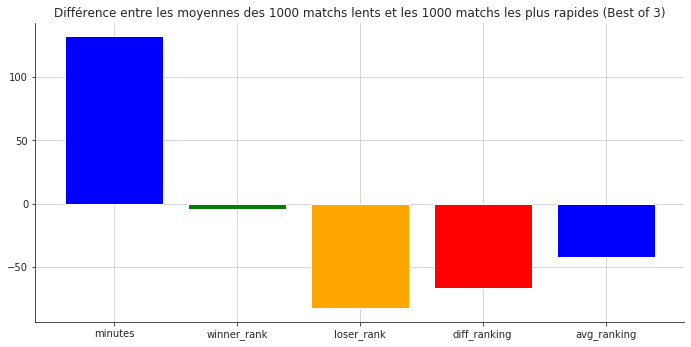

In [84]:
plt.figure(figsize=(10,5))
plt.grid()
plt.tight_layout(pad=2)
plt.bar(['minutes', 'winner_rank',  'loser_rank', 'diff_ranking', 'avg_ranking'],diff_between_lent_rapide_b03, color=['blue', 'green', 'orange', 'red'])
plt.title('Différence entre les moyennes des 1000 matchs lents et les 1000 matchs les plus rapides (Best of 3)')
sns.despine()
plt.show()

In [80]:
diff_between_lent_rapide_b05 =[top_1000_lents_b05['minutes'].mean()-top_1000_rapides_b05['minutes'].mean(),
top_1000_lents_b05['winner_rank'].mean()-top_1000_rapides_b05['winner_rank'].mean(),
top_1000_lents_b05['loser_rank'].mean()-top_1000_rapides_b05['loser_rank'].mean(),
top_1000_lents_b05['diff_ranking'].mean()-top_1000_rapides_b05['diff_ranking'].mean(),
top_1000_lents_b05['avg_ranking'].mean()-top_1000_rapides_b05['avg_ranking'].mean()]

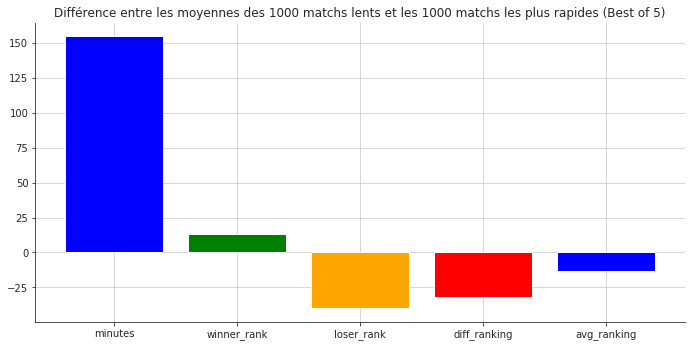

In [83]:
plt.figure(figsize=(10,5))
plt.grid()
plt.tight_layout(pad=2)
plt.bar(['minutes', 'winner_rank',  'loser_rank', 'diff_ranking', 'avg_ranking'],diff_between_lent_rapide_b05, color=['blue', 'green', 'orange', 'red'])
sns.despine()
plt.title('Différence entre les moyennes des 1000 matchs lents et les 1000 matchs les plus rapides (Best of 5)')
plt.show()

On constate via différence entre le top 1000 des matchs les plus lents et des matchs les plus rapides que les matchs qui dure plus longtemps (lents) on tendance à avoir un niveau plus homogène. <br>
La bar rouge de la colonne diff_ranking nous indique que plus un matchs est "lents" plus la différence de ranking est faible avec (-70 classements de différence en moins entre les deux joueurs pour les best of 3 et -35 pour les best of 5).<br>
La même analyse sur la colonne avg ranking nous indique que le niveau moyen est légérement meilleurs dans les matchs les plus longs.

In [86]:
data.groupby('surface')['minutes'].sort_values('tourney_date')

AttributeError: Cannot access callable attribute 'sort_values' of 'SeriesGroupBy' objects, try using the 'apply' method

In [87]:
df = pd.DataFrame()

In [88]:
df['int'] = [i for i in range(50)]

In [89]:
df

,int
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [96]:
df['roll']=df.rolling(3, win_type='triang').mean()

In [99]:
df = pd.Series(data=np.arange(10), 
               index=pd.date_range('2000', periods=10))

In [100]:
df.head()

2000-01-01    0
2000-01-02    1
2000-01-03    2
2000-01-04    3
2000-01-05    4
Freq: D, dtype: int64

In [103]:
df['roll']=df.rolling(2, closed='left').mean()

ValueError: closed only implemented for datetimelike and offset based windows

In [102]:
df

2000-01-01 00:00:00                                                    0
2000-01-02 00:00:00                                                    1
2000-01-03 00:00:00                                                    2
2000-01-04 00:00:00                                                    3
2000-01-05 00:00:00                                                    4
2000-01-06 00:00:00                                                    5
2000-01-07 00:00:00                                                    6
2000-01-08 00:00:00                                                    7
2000-01-09 00:00:00                                                    8
2000-01-10 00:00:00                                                    9
roll                   2000-01-01    NaN
2000-01-02    NaN
2000-01-03...
dtype: object

In [ ]:
def rolling_avg(seq, period):
    res = []
    for i in period:
        